# COS 3a Exercise 12

---
Submission until 21/01/2025 12:00 p.m.

<span style="color:red">You will need to install pyscf for this exercise manually (`pip install pyscf`) in the corresponding environment. </span>

## Tutorial

### Davidson Algorithm

In this exercise, we will learn about a very prominent algorithm that is used in most $ab~initio$ excited-state quantum chemical methods. The so-called Davidson algorithm is a numerical procedure that allows finding some $K\leq N$ eigenvalues of a matrix $\mathbf{A}$ efficiently, where $\mathbf{A}\in \mathbb{R}^{N\times N}$ for example. As you might expect using these kind of approximate eigenvalue solvers over a full diagonalization of the corresponding matrices is only necessary in cases where sufficiently large matrices are considered. 
One such example is the orbital rotation hessian matrix $\mathbf{A}$ of the Tamm-Dancoff approximation (TDA) eigenvalue problem:
$$
\mathbf{A}\mathbf{X}= \mathbf{X}\boldsymbol{\omega} 
$$
whose eigenvalues and -vectors are of interest, e.g. for the computation of spectroscopical properties. From the equation of the matrix element $A_{ia,jb}$ (see lecture):
$$
\delta_{ij}\delta_{ab}(\epsilon_a - \epsilon_i) + \lbrack ia|jb \rbrack - \lbrack ij|ab \rbrack, \\ i,j \in n_\mathrm{occ},~a,b\in n_\mathrm{virt}
$$
we see that $\dim(\mathbf{A}) = ((n_\mathrm{occ}n_\mathrm{virt}), (n_\mathrm{occ}n_\mathrm{virt}))$.

Let's consider the objective of computing the absorption spectrum of Benzene by means of a TDA calculation. Below, you find the code to do the ground state calculation with `pyscf` when using only a "small" def2-SVP basis set:


In [4]:
from pyscf import gto, dft, tddft

mol = gto.Mole()
mol.build(
    atom = "data/exercise_4/benzene.xyz",
    basis = '6-31G*',
)

mf = dft.RKS(mol)
mf.xc = 'pbe0'
mf.kernel()


converged SCF energy = -231.95889656896


np.float64(-231.9588965689598)

In [5]:
C = mf.mo_coeff 
occ = mf.mo_occ
occmo = C[:,occ==2]
virtmo = C[:,occ==0]
nocc, nvirt = occmo.shape[-1], virtmo.shape[-1]
print(nocc *nvirt)

1575


In [6]:
mytd = tddft.TDA(mf)
mytd.nstates = 2
A = mytd.get_ab()[0] # Get A matrix only

In [7]:
A = A.reshape(nocc * nvirt, nocc* nvirt) # Reshape 4D tensor to matrix
print(A.shape)

(1575, 1575)


Already for this small test case, $\mathbf{A}$ gets rather large ($\sim2000 \times 2000$). Constructing the full $\mathbf{A}$ matrix is costly already, and it quickly becomes unfeasible to do a full diagonalization (scales roughly $\mathcal{O}(N^3)$, where $N$ is a dimension of the matrix) to obtain the complete eigenvalue spectrum (here: excitation energies). 

More often we are interested in determining a few eigenvalues, for example when trying to simulate UV-Vis absorption spectra (restricted energy range of particular interest). The Davidson algorithm is a much more economic choice to diagonalizing $\mathbf{A}$ completely in the sense that only a subspace of $\mathbf{A}$ is actually diagonalized, and we can obtain some targeted lowest (or highest) $k$ eigenvalues and -vectors instead. 

Starting from the Rayleigh-Ritz projection formula, we can project $\mathbf{A}$ onto a subspace spanned by a set of $m$ trial vectors $\{\vec{v}_i\} = \mathbf{V}$ (orthonormal):
\begin{align}
\mathbf{A}^\prime = \mathbf{V}^T \mathbf{A} \mathbf{V}
\end{align}\tag{1}
In the Davidson algorithm, we initialize a set $\mathbf{V}\in \mathbb{R}^{N \times m}$ where $m << N$ (m is incremented during the procedure). Say, for example, we start with two trial vectors such that $\mathbf{V}\in \mathbb{R}^{N \times 2}$. We compute $\mathbf{A}^\prime$ using eq. 1. 

Next, we diagonalize $\mathbf{A}^\prime$ ($\dim(\mathbf{A}^\prime) = m \times m$) and obtain eigenvectors $\vec{X}_i$ and eigenvalues $\omega^\prime_i$. The eigenvalue equation reads:
$$
\mathbf{A}^\prime \vec{X}^\prime_i = \vec{X}^\prime_i \omega^\prime_i \,.
$$
These eigenvectors will then be used to update the trial vector space. We compute the residuals 
$$\vec{r}_i = \mathbf{A}\mathbf{V}\mathbf{X}^\prime - \omega_i^\prime\mathbf{V}\mathbf{X}^\prime_i
$$ 
from $\mathbf{X}_i^\prime$. These are zero if we find the "true" eigenvalues of $\mathbf{A}$. We use these to determine convergence, since they should be below some threshold $\tau$ such that the approximated eigenvalues of $\mathbf{A}$ are reasonably accurate. If we did not converge within this iteration (subspace spanned by $\mathbf{V}$ does not approximate the eigenvectors sufficiently), we add the residuals $\vec{r}_i$ to our subspace: $\mathbf{V}= \lbrack \{\mathbf{v_i}\}\cup\{\vec{r}_i\} \rbrack$ and continue. More (mathematical) details can be found [here](https://gqcg-res.github.io/knowdes/the-davidson-diagonalization-method.html) and [here](https://joshuagoings.com/2013/08/23/davidsons-method/) in case you are interested. 
 
For the sake of this exercise, we will use the Davidson algorithm mainly for demonstration purposes on how to deal with CIS-like excited-state eigenvalue problems. 

In [8]:
# Imports the custom implementation of a Davidson solver
from davidson import Davidson

import numpy as np
import matplotlib.pyplot as plt
import time

## Task 1

Write a function to determine the "sparsity" and "density" of a matrix $\mathbf{A}$. We define sparsity and density $\mathcal{D}$ of a matrix $\mathbf{M}$ as:
$$
\mathcal{S} = 1 - \mathcal{D} = 1 - \frac{N}{n\cdot m}
$$
where $N$ is the number of non-zero matrix elements and $\dim(\mathbf{A}) =(n,m)$. Include an optional argument in your function that recognizes numerical "near-zero" cases correctly.

Implement a function that builds diagonally-dominant, i.e. largest contributions on the diagonal, random symmetric matrices (use `np.random.randn`) with varying sparsity/density. 

Investigate the time needed to do a full diagonalization (`np.linalg.eigh`) against that of the provided Davidson solver (`davidson.Davidson`) for matrices of different sparsity. Summarize your results in a barplot giving the matrix dimension and CPU time needed. 

Briefly comment for which types of matrices you expect the Davidson solver to pay-off more in regard to the timing (sparse or dense matrices). Give an explanation why you think this is the case. Also explain whether this generally true or just for our implementation? What "inputs" affect the convergence behaviour of our Davidson solver? 
Explain in your own words what the residual equation tells you about the Davidson and what is it good for (except for the convergence criterion).  

<span style="color:red"> Solution: </span>

Large, sparse matrices are ideal to use a Davidson solver/our solver for. 
Our chosen basis vectors are close to the target eigenvectors in case of diag. dom. matrices. 
Generally, the "input" trial vectors strongly affect the convergence of your solver, since matrices that are not diagonally-dominant will feature eigenvectors that are rather different from these trial vectors. Hence, more iterations (larger vectorspace) is needed to get these eigenvectors. In very bad cases, the dimension of the subspace spanned by $\mathbf{V}$ can even become so large that the actual time savings would become negligible, or you run into memory issues.
The residual describes a) how far our solution (eigenvectors, -values) are away from the actual eigenvectors (close to the mentioned convergence aspect) and b) dictates the search direction of our solver(in the vector space of $\mathbf{A}$), since correctly identified eigenvectors (/-values) are numerically close to zero if the eigenvectors are "matched". 
The search direction of the solver is (close to) optimal when the matrix structure is sparse, because few components (entries) of the eigenvectors mix. 

In [9]:
def gen_ddm(N : int = 1000, damp: float = 1e-4) -> np.array:
    """ Generate diagonally-dominant random symmetric matrix. 
    
    Args:
        N (int): Dimension of symm. mat. Def.: 1000.
        damp (float): Dampening factor to introduce sparsity. Def.: 1e-4.

    Returns:
        ddm (np.array): Diag-dom. mat. (dim: N,N) 

    """

    A = np.zeros((N, N))
    # Fill diag. with increasing integers
    A[np.arange(N), np.arange(N)] = np.arange(1, N + 1)
    # Add dampened contributions to diag. and off-diag.
    A += damp*np.random.randn(N,N) 
    # Make symmetric
    A = (A.T + A)/2 
    return A

def calc_sparse(A : np.array, thres : float = 1e-4)-> float:
    """ Compute sparsity of a matrix using a given prec. to identify zeros.

    sparsity = 1 - nonzero_elements/ total_els  

    Args:
        A (np.array): Matrix to det. sparsity for.
        thres (float): Thres below which elements are treated as 0. Def.: 1e-7.

    Returns:
        sparsity (float): Sparsity of A.
        dens (float): "Density" of A.

    """

    total_elements = A.size
    if total_elements == 0:
        raise ValueError("Input matrix A must not be empty.")

    nonzero_elements = np.sum(np.abs(A) > thres)
    dens = (nonzero_elements / total_elements)
    sparsity = 1 - dens
    return sparsity, dens


In [10]:
## Showcase example

A = gen_ddm(10, 1e-4)
e, v, _ = Davidson(A, 5)
print(len(e))

t0 = time.time()
e_, v_ = np.linalg.eigh(A)
t1 = time.time()
print(f"Time Full diag.: {t1-t0:.2f} s")
_, d = calc_sparse(A)
print(d)

_, d = calc_sparse(np.random.randn(10,10) )
print(d)

5
Time Full diag.: 0.00 s
0.2
1.0


In [11]:
matsize = [500, 1000]
damps = [1e-2, 1e-6]

resD, resF, S = [], [], []
for d in damps:
    for mat in matsize: 
        #print(f"Matsize {mat}, damping: {d}")
        # Do tests with Davidson
        A = gen_ddm(mat, damp = d)
        _, _, t = Davidson(A, 6, printinfo=False)
        resD.append(t)

        # Do tests with Full diag.
        t0 = time.time()
        _, _ = np.linalg.eigh(A)
        resF.append(time.time() - t0)
        # Add sparsity result for plot
        S.append(calc_sparse(A, thres=d)[0])


Text(0.5, 0, 'First dimension of matrix')

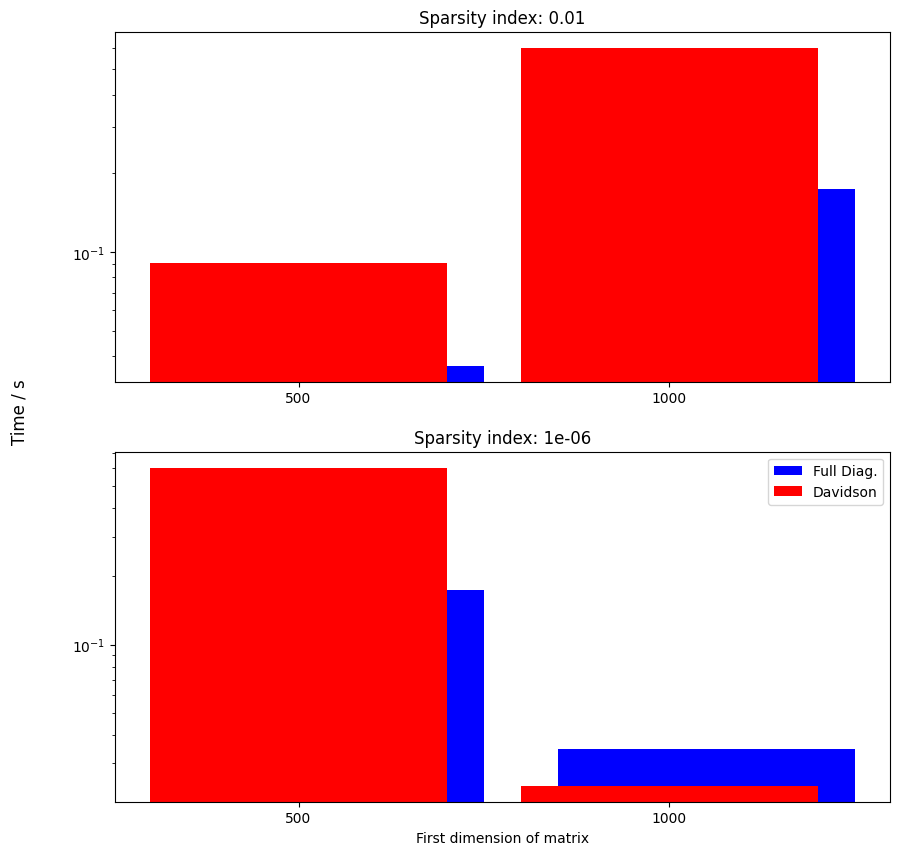

In [12]:
fig, axes = plt.subplots(len(damps),1, figsize=(10,10))
idx = 0
for idx, ax in enumerate(axes):
    ax.set_yscale("log")
    ax.bar(np.arange(len(matsize))+0.1, resF[idx:len(matsize)+idx], color = "blue", label = "Full Diag.")
    ax.bar(np.arange(len(matsize)), resD[idx:len(matsize)+idx], color = "red", label = "Davidson")
    #ax.set_xlim(-1,len(matsize))
    ax.set_title(f"Sparsity index: {damps[idx]}")
    idx += len(matsize)
    ax.set_xticks(np.arange(len(matsize)), matsize)
fig.supylabel("Time / s")
axes[-1].legend()
ax.set_xlabel("First dimension of matrix")

## Task 2 

Take the above example of Benzene (PBE0/def2-SVP) and compute the first 10 excited states using TDA with `pyscf`. Use 
1) the built-in solver of `pyscf`
2) the provided custom Davidson implementation 
3) a full diagonalization of $\mathbf{A}$ 

to determine the excitation energies. Compare the timings and discuss the results. 
How do you expect the order of fastest--lowest solver changes for larger systems? Briefly explain your thoughts.

<u>Opt:</u> If the execution with def2-SVP takes too long, you can also choose a slightly smaller basis set like 6-31G* for testing purposes.

<span style="color:red"> Solution: </span>

In [13]:
# Raise the number of roots and execute cases 1-3
nroots = 10
mytd = tddft.TDA(mf)
mytd.nstates = nroots
t0 = time.time()
mytd.kernel()
print(f"1) Built-in pyscf: {time.time() - t0:.2f} s")
print(f"1) Eigenvalues: {mytd.e}")

Excited State energies (eV)
[5.57221193 6.57597811 7.85347915 7.95929548 7.95929579 7.96664828
 8.01686352 8.01688538 8.20373381 8.20403626]
1) Built-in pyscf: 17.10 s
1) Eigenvalues: [0.20477501 0.24166274 0.28861004 0.29249872 0.29249873 0.29276893
 0.2946143  0.29461511 0.30148166 0.30149277]


In [14]:
t0 = time.time()
A = mytd.get_ab()[0] # Get A matrix only
A = A.reshape(nocc * nvirt, nocc* nvirt) # Reshape 4D tensor to matrix
ev, evec, t = Davidson(A,nroots)
print(f"2) Custom Davidson solver: {time.time() -t0} s")
print(t)
print(f"2) Eigenvalues: {ev}")

2) Custom Davidson solver: 31.651561975479126 s
3.0425732135772705
2) Eigenvalues: [0.20477568 0.24167468 0.28861006 0.29249919 0.29249921 0.29276916
 0.29462418 0.29462499 0.3014823  0.30149342]


In [15]:
t0 = time.time()
A = mytd.get_ab()[0] # Get A matrix only
A = A.reshape(nocc * nvirt, nocc* nvirt) # Reshape 4D tensor to matrix
ev, evec = np.linalg.eigh(A)
print(f"3) Full diagonalization with numpy: {time.time() - t0:.2f} s")
print(f"3) Eigenvalues: {ev[:10]}")

3) Full diagonalization with numpy: 28.65 s
3) Eigenvalues: [0.20477501 0.24166274 0.28861004 0.29249872 0.29249873 0.29276893
 0.2946143  0.29461511 0.30148166 0.30149277]
